In [20]:
import torch
from torch import nn, optim
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('white')
sys.path.insert(0, '../')
#from tta_agg_models import TTARegression, TTAPartialRegression, GPS
from utils.gpu_utils import restrict_GPU_pytorch
import numpy as np
from utils.aug_utils import invert_aug_list
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
restrict_GPU_pytorch('0')
class TTAPartialRegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even',coeffs=[]):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.coeffs = nn.Parameter(torch.randn((n_augs,1 ), requires_grad=True, dtype=torch.float))
        self.temperature = temp_scale
        if len(coeffs):
            self.coeffs = nn.Parameter(torch.Tensor(coeffs), requires_grad=True)
        else:
            if initialization == 'even':
                self.coeffs.data.fill_(1.0/n_augs)
            elif initialization== 'original':
                self.coeffs.data[0,:].fill_(1)
                self.coeffs.data[1,:].fill_(0)

    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = torch.matmul(x.transpose(1, 2), self.coeffs / torch.sum(self.coeffs, axis=0))
        return mult.squeeze()

class TTARegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even'):
        super().__init__()
        
        if initialization == 'even':
            self.coeffs = nn.Parameter(torch.randn((n_augs, n_classes), requires_grad=True, dtype=torch.float))
            self.coeffs.data.fill_(1.0/n_augs) 
        else:
            coeffs = torch.cat([torch.Tensor(initialization) for i in range(n_classes)], axis=1)
            self.coeffs = nn.Parameter(coeffs, requires_grad = True)

        self.temperature = temp_scale
    
    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = self.coeffs * x
        return mult.sum(axis=1)

dataset_name_dict = {'flowers102':'Flowers102', 'imnet':'ImageNet',
                 'cifar100': 'CIFAR100'}

# Uncomment line for plots specific to each dataset
# dataset, n_classes = 'imnet', 1000
dataset, n_classes = 'flowers102', 102

policy = 'five_crop_hflip_scale'
n_augs = 30
agg_models_dir = '../' + dataset + '/' + policy + '/agg_models'
model_name = 'resnet50'


aug_list = np.load('../' + dataset + '/' + policy + '/aug_list.npy')
aug_order = np.load('../' + dataset + '/' + policy + '/aug_order.npy')

aug_name = 'combo'
aug_model_path = agg_models_dir + '/'+model_name+'/'+aug_name + '/partial_lr.pth'
aug_model = TTAPartialRegression(n_augs,n_classes,1,'even')
aug_model.load_state_dict(torch.load(aug_model_path))
aug_model.eval()
aug_coeffs = aug_model.coeffs.detach().cpu().numpy()
coeffs = aug_coeffs


Using GPU:0


In [21]:
aug_list = np.load('../' + dataset + '/' + policy + '/aug_list.npy')
aug_order = np.load('../' + dataset  + '/' + policy + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)
print("List of augmentations with non-zero weights, along with learned weight")
[(aug_names[i], coeffs[i][0]) for i in np.where(coeffs > 0)[0]]

List of augmentations with non-zero weights, along with learned weight


[('no hflip,upper left crop,0.0% zoomed in', 0.028611243),
 ('no hflip,upper left crop,4.0% zoomed in', 0.021924611),
 ('no hflip,lower left crop,0.0% zoomed in', 0.04023848),
 ('no hflip,lower left crop,4.0% zoomed in', 0.006447591),
 ('no hflip,lower right,0.0% zoomed in', 0.032283567),
 ('no hflip,lower right,4.0% zoomed in', 0.040941644),
 ('no hflip,upper right crop,0.0% zoomed in', 0.021264138),
 ('no hflip,upper right crop,4.0% zoomed in', 0.03497406),
 ('no hflip,center crop,0.0% zoomed in', 0.07165731),
 ('no hflip,center crop,4.0% zoomed in', 0.058629572),
 ('hflip,upper left crop,0.0% zoomed in', 0.060986813),
 ('hflip,upper left crop,4.0% zoomed in', 0.04808944),
 ('hflip,lower left crop,0.0% zoomed in', 0.06783164),
 ('hflip,lower left crop,4.0% zoomed in', 0.026838988),
 ('hflip,lower left crop,10.% zoomed in', 0.014454059),
 ('hflip,lower right,0.0% zoomed in', 0.046559468),
 ('hflip,lower right,4.0% zoomed in', 0.017741028),
 ('hflip,upper right crop,0.0% zoomed in', 0.

In [22]:
results = []
for i in range(len(aug_list)):
    aug_params = aug_list[i]
    coeff = coeffs[i]
    results.append({'coeff': coeff, 'hflip': aug_params[0], 'five_crop': aug_params[1],
                    'scale': aug_params[2]})
results_df = pd.DataFrame(results)

(-0.01, 0.11)

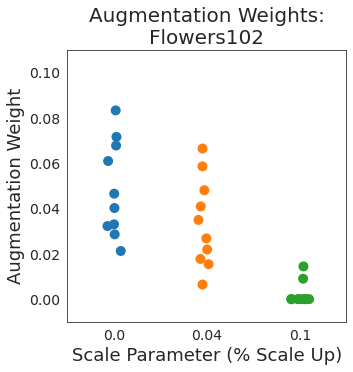

In [23]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(5, 5))
results_df['scale'] = results_df['scale'].round(2)
ax = sns.stripplot(x='scale', y='coeff', data=results_df, size=10)
plt.title("Augmentation Weights:\n" + dataset_name_dict[dataset] )
plt.ylabel("Augmentation Weight")
plt.xlabel("Scale Parameter (% Scale Up)")
#ax.set_xticklabels(['0.0', '4.0', '10.0'])
plt.ylim(-.01, .11)
#ax.set_yticklabels([])
#ax.set_ylabel("")
#plt.tight_layout()